# Сверточные нейронные сети (CNN)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Фиксация random seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Устройство (GPU если доступна)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

Используется устройство: cuda


## 1. Основы Conv2d и MaxPool2d

### 1.1 Базовая свертка

In [2]:
# Создаем тестовое изображение 32x32 RGB
x = torch.randn(1, 3, 32, 32)
print(f'Входной тензор: {x.shape}')

# Базовая свертка 3x3
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
out1 = conv1(x)
print(f'После Conv2d(3, 16, kernel_size=3): {out1.shape}')
print(f'Размер: (32 - 3 + 1) = {32 - 3 + 1}')

# Свертка с padding
conv2 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
out2 = conv2(x)
print(f'\nПосле Conv2d(3, 16, kernel_size=3, padding=1): {out2.shape}')
print('Размер сохранен благодаря padding=1')

# Свертка с stride
conv3 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
out3 = conv3(x)
print(f'\nПосле Conv2d(3, 16, kernel_size=3, stride=2, padding=1): {out3.shape}')
print(f'Размер: floor((32 + 2*1 - 3) / 2) + 1 = {(32 + 2*1 - 3) // 2 + 1}')

Входной тензор: torch.Size([1, 3, 32, 32])
После Conv2d(3, 16, kernel_size=3): torch.Size([1, 16, 30, 30])
Размер: (32 - 3 + 1) = 30

После Conv2d(3, 16, kernel_size=3, padding=1): torch.Size([1, 16, 32, 32])
Размер сохранен благодаря padding=1

После Conv2d(3, 16, kernel_size=3, stride=2, padding=1): torch.Size([1, 16, 16, 16])
Размер: floor((32 + 2*1 - 3) / 2) + 1 = 16


### 1.2 Влияние параметров на размер выхода

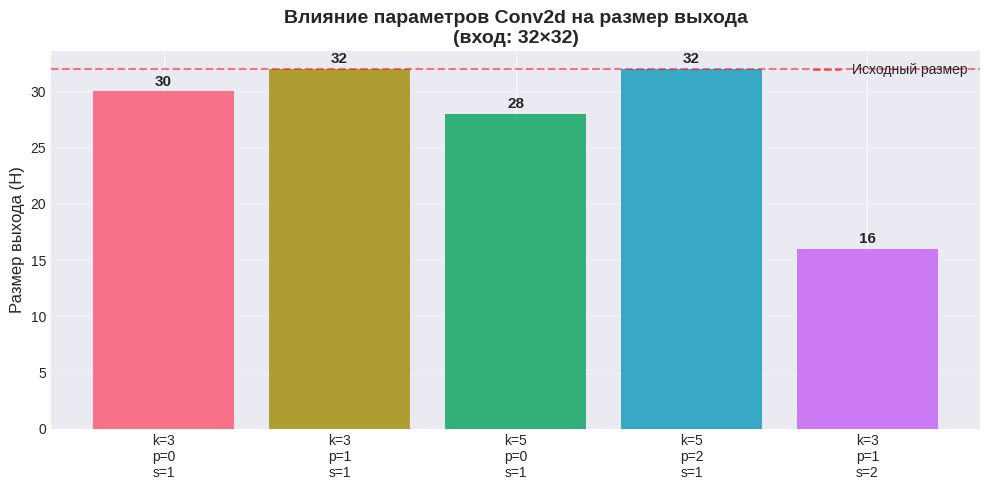

In [3]:
# Таблица с различными конфигурациями
configs = [
    {'kernel': 3, 'padding': 0, 'stride': 1},
    {'kernel': 3, 'padding': 1, 'stride': 1},
    {'kernel': 5, 'padding': 0, 'stride': 1},
    {'kernel': 5, 'padding': 2, 'stride': 1},
    {'kernel': 3, 'padding': 1, 'stride': 2},
]

results = []
for cfg in configs:
    conv = nn.Conv2d(3, 16, kernel_size=cfg['kernel'], 
                     padding=cfg['padding'], stride=cfg['stride'])
    out = conv(x)
    results.append(out.shape[2])  # высота

# Визуализация
fig, ax = plt.subplots(figsize=(10, 5))
x_pos = np.arange(len(configs))
bars = ax.bar(x_pos, results, color=sns.color_palette('husl', len(configs)))

ax.set_ylabel('Размер выхода (H)', fontsize=12)
ax.set_title('Влияние параметров Conv2d на размер выхода\n(вход: 32×32)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"k={c['kernel']}\np={c['padding']}\ns={c['stride']}" for c in configs])
ax.axhline(y=32, color='red', linestyle='--', alpha=0.5, label='Исходный размер')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем значения над столбцами
for i, (bar, val) in enumerate(zip(bars, results)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(val), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 1.3 MaxPooling и его эффект

In [4]:
# MaxPool2d
pool = nn.MaxPool2d(kernel_size=2, stride=2)
x_pooled = pool(out2)
print(f'До pooling: {out2.shape}')
print(f'После MaxPool2d(2, 2): {x_pooled.shape}')
print('Размер уменьшен в 2 раза по высоте и ширине')

# AdaptiveAvgPool2d
adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
x_adaptive = adaptive_pool(out2)
print(f'\nПосле AdaptiveAvgPool2d((1, 1)): {x_adaptive.shape}')
print('Global Average Pooling - всегда выход 1×1')

До pooling: torch.Size([1, 16, 32, 32])
После MaxPool2d(2, 2): torch.Size([1, 16, 16, 16])
Размер уменьшен в 2 раза по высоте и ширине

После AdaptiveAvgPool2d((1, 1)): torch.Size([1, 16, 1, 1])
Global Average Pooling - всегда выход 1×1


### 1.4 Dilated Convolution

In [5]:
# Обычная свертка
conv_normal = nn.Conv2d(3, 16, kernel_size=3, padding=1)
# Dilated свертка с dilation=2
conv_dilated = nn.Conv2d(3, 16, kernel_size=3, padding=2, dilation=2)

out_normal = conv_normal(x)
out_dilated = conv_dilated(x)

print('Обычная свертка 3×3:')
print(f'  Выход: {out_normal.shape}')
print(f'  Receptive Field: 3×3')
print(f'  Параметров: {sum(p.numel() for p in conv_normal.parameters()):,}')

print('\nDilated свертка 3×3 (dilation=2):')
print(f'  Выход: {out_dilated.shape}')
print(f'  Effective kernel: 3 + (3-1)*(2-1) = 5×5')
print(f'  Receptive Field: 5×5')
print(f'  Параметров: {sum(p.numel() for p in conv_dilated.parameters()):,}')

Обычная свертка 3×3:
  Выход: torch.Size([1, 16, 32, 32])
  Receptive Field: 3×3
  Параметров: 448

Dilated свертка 3×3 (dilation=2):
  Выход: torch.Size([1, 16, 32, 32])
  Effective kernel: 3 + (3-1)*(2-1) = 5×5
  Receptive Field: 5×5
  Параметров: 448


## 2. Загрузка и подготовка CIFAR-10

In [6]:
# Трансформации для обучающей выборки (с аугментацией)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Трансформации для тестовой выборки (без аугментации)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Загрузка датасета
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Классы CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Обучающая выборка: {len(train_dataset)} изображений')
print(f'Тестовая выборка: {len(test_dataset)} изображений')
print(f'Классов: {len(classes)}')
print(f'Батчей (train): {len(train_loader)}, Батчей (test): {len(test_loader)}')

100%|██████████| 170M/170M [01:37<00:00, 1.76MB/s] 
/home/vladg00dman/Projects/Olympiads/ARSO_AI_practise/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Обучающая выборка: 50000 изображений
Тестовая выборка: 10000 изображений
Классов: 10
Батчей (train): 391, Батчей (test): 79


### 2.1 Визуализация примеров из датасета

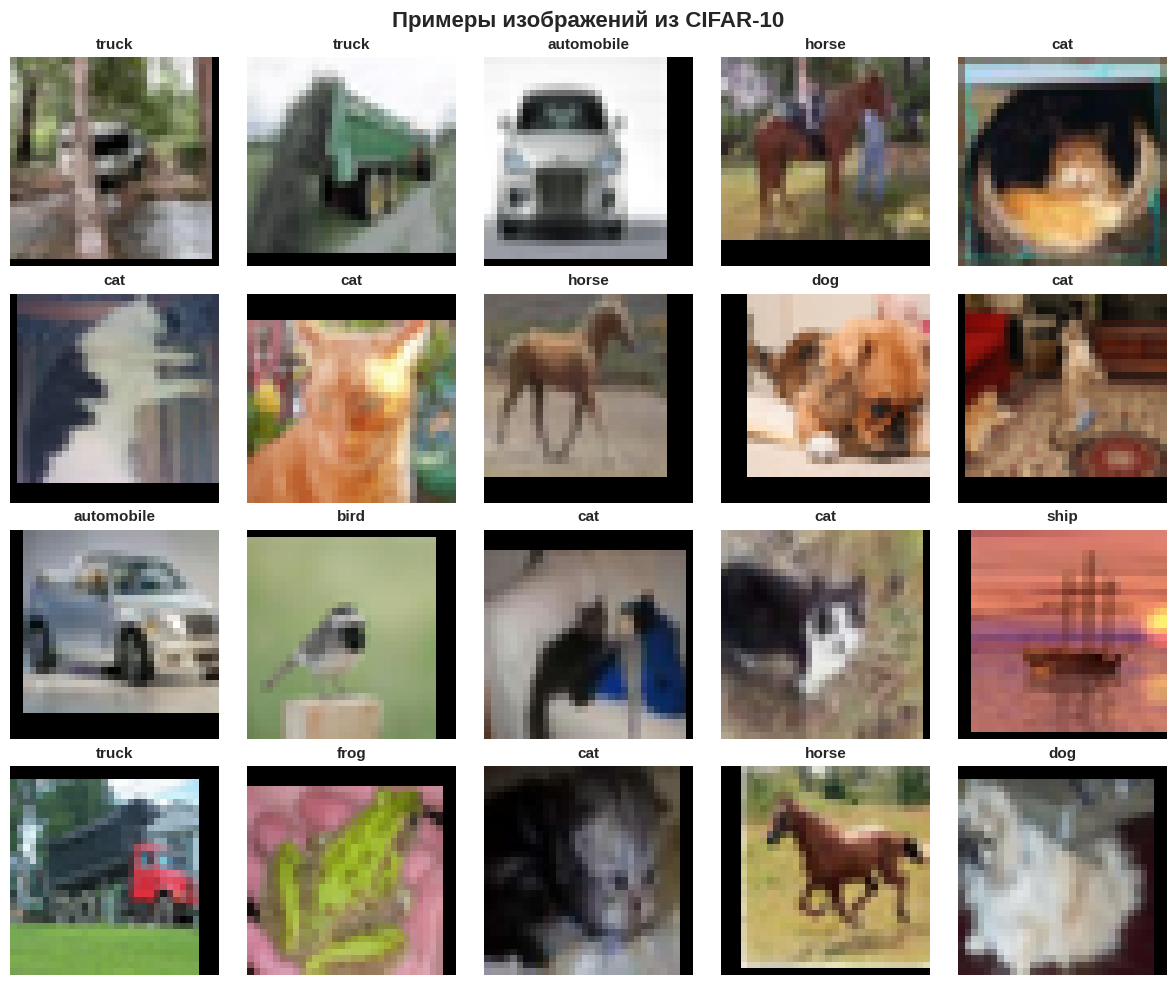

In [8]:
# Функция для денормализации изображения
def denormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    return img * std + mean

# Получаем батч изображений
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Визуализация 20 изображений
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Примеры изображений из CIFAR-10', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(classes[labels[idx]], fontsize=11, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.2 Распределение классов

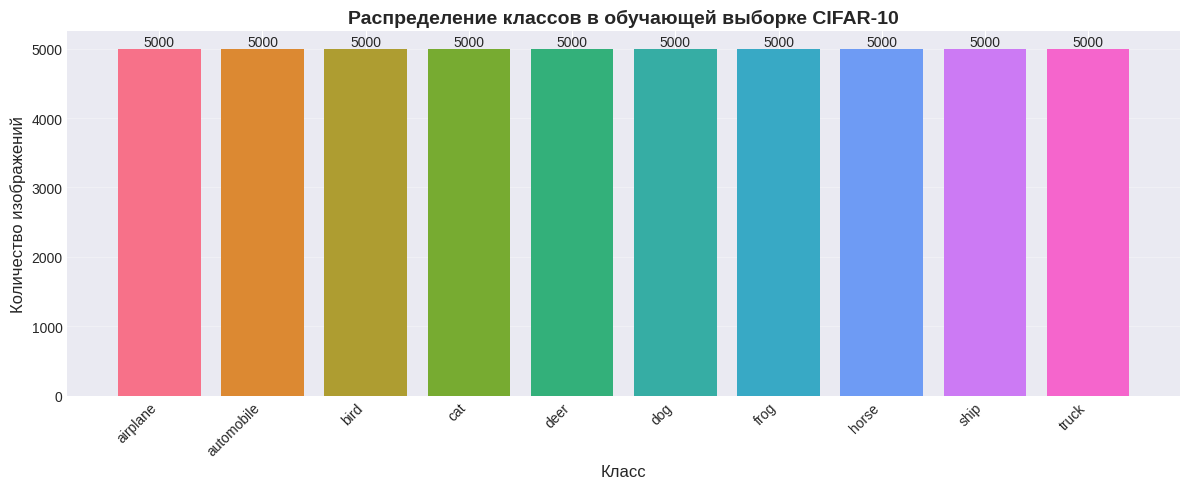

Датасет CIFAR-10 сбалансирован: по 5000 изображений каждого класса


In [9]:
# Подсчет количества изображений каждого класса
train_labels = [label for _, label in train_dataset]
class_counts = np.bincount(train_labels)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(classes, class_counts, color=sns.color_palette('husl', len(classes)))
ax.set_xlabel('Класс', fontsize=12)
ax.set_ylabel('Количество изображений', fontsize=12)
ax.set_title('Распределение классов в обучающей выборке CIFAR-10', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print('Датасет CIFAR-10 сбалансирован: по 5000 изображений каждого класса')

## 3. Определение архитектуры CNN

In [10]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        
        # Блок 1: Conv -> BN -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 32x32x32
        self.bn1 = nn.BatchNorm2d(32)
        
        # Блок 2: Conv -> BN -> ReLU -> Pool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 16x16x64
        self.bn2 = nn.BatchNorm2d(64)
        
        # Блок 3: Conv -> BN -> ReLU -> Pool
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 8x8x128
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Блок 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> 32x16x16
        
        # Блок 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> 64x8x8
        
        # Блок 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> 128x4x4
        
        # Flatten
        x = x.view(x.size(0), -1)  # -> 2048
        
        # FC слои
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Создаем модель
model = CIFAR10_CNN().to(device)

# Подсчет параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Всего параметров: {total_params:,}')
print(f'Обучаемых параметров: {trainable_params:,}')
print(f'\nАрхитектура модели:')
print(model)

Всего параметров: 620,810
Обучаемых параметров: 620,810

Архитектура модели:
CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 3.1 Визуализация архитектуры

In [ ]:
# Проверка размерностей на каждом слое
def trace_model(model, input_size=(1, 3, 32, 32)):
    x = torch.randn(input_size).to(device)
    shapes = [('Input', x.shape)]
    
    # Блок 1
    x = model.conv1(x)
    shapes.append(('Conv1', x.shape))
    x = model.bn1(x)
    x = F.relu(x)
    x = model.pool(x)
    shapes.append(('Pool1', x.shape))
    
    # Блок 2
    x = model.conv2(x)
    shapes.append(('Conv2', x.shape))
    x = model.bn2(x)
    x = F.relu(x)
    x = model.pool(x)
    shapes.append(('Pool2', x.shape))
    
    # Блок 3
    x = model.conv3(x)
    shapes.append(('Conv3', x.shape))
    x = model.bn3(x)
    x = F.relu(x)
    x = model.pool(x)
    shapes.append(('Pool3', x.shape))
    
    # Flatten
    x = x.view(x.size(0), -1)
    shapes.append(('Flatten', x.shape))
    
    # FC
    x = model.fc1(x)
    shapes.append(('FC1', x.shape))
    x = model.fc2(x)
    shapes.append(('FC2 (Output)', x.shape))
    
    return shapes

shapes = trace_model(model)

print('Размерности на каждом слое:')
print('=' * 50)
for name, shape in shapes:
    print(f'{name:20s}: {str(tuple(shape)):20s} | Elements: {np.prod(shape[1:]):,}')
print('=' * 50)

## 4. Обучение модели

In [ ]:
# Loss и optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# История обучения
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Training loop
num_epochs = 20

print('Начало обучения...')
print('=' * 80)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print('=' * 80)
print('Обучение завершено!')
print(f'Лучшая точность на тесте: {max(history["test_acc"]):.2f}%')

### 4.1 Визуализация процесса обучения

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График Loss
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Эпоха', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss в процессе обучения', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# График Accuracy
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Эпоха', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy в процессе обучения', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f'Финальная точность на train: {history["train_acc"][-1]:.2f}%')
print(f'Финальная точность на test: {history["test_acc"][-1]:.2f}%')
print(f'Gap (overfitting): {history["train_acc"][-1] - history["test_acc"][-1]:.2f}%')

## 5. Анализ результатов

### 5.1 Confusion Matrix

In [ ]:
# Получаем предсказания для всей тестовой выборки
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Количество'}, linewidths=0.5)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.title('Confusion Matrix для CIFAR-10 CNN', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Нормализованная Confusion Matrix (в процентах)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Процент'}, linewidths=0.5, vmin=0, vmax=100)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.title('Нормализованная Confusion Matrix (%) для CIFAR-10 CNN', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 5.2 Точность по классам

In [ ]:
# Подсчет точности для каждого класса
class_correct = [0] * 10
class_total = [0] * 10

for i in range(len(all_labels)):
    label = all_labels[i]
    class_total[label] += 1
    if all_labels[i] == all_preds[i]:
        class_correct[label] += 1

class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(10)]

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(classes, class_accuracy, color=sns.color_palette('coolwarm', len(classes)))
ax.set_xlabel('Класс', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Точность модели по классам', fontsize=14, fontweight='bold')
ax.axhline(y=np.mean(class_accuracy), color='red', linestyle='--', 
           linewidth=2, label=f'Средняя: {np.mean(class_accuracy):.2f}%')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Добавляем значения над столбцами
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Вывод статистики
print('Точность по классам:')
print('=' * 40)
for i, class_name in enumerate(classes):
    print(f'{class_name:12s}: {class_accuracy[i]:5.2f}%')
print('=' * 40)
print(f'Средняя: {np.mean(class_accuracy):.2f}%')

### 5.3 Примеры правильных и неправильных предсказаний

In [ ]:
# Получаем батч изображений
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Предсказания
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Правильные предсказания
correct_mask = (predicted == labels)
correct_indices = torch.where(correct_mask)[0][:10]

# Неправильные предсказания
incorrect_mask = (predicted != labels)
incorrect_indices = torch.where(incorrect_mask)[0][:10]

def show_predictions(indices, images, labels, predicted, title):
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx, ax in zip(indices, axes.flat):
        img = denormalize(images[idx].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        true_label = classes[labels[idx]]
        pred_label = classes[predicted[idx]]
        
        if labels[idx] == predicted[idx]:
            color = 'green'
            title_text = f'✓ {pred_label}'
        else:
            color = 'red'
            title_text = f'✗ True: {true_label}\nPred: {pred_label}'
        
        ax.set_title(title_text, fontsize=10, fontweight='bold', color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Показываем правильные предсказания
show_predictions(correct_indices, images, labels, predicted, 
                'Правильные предсказания')

# Показываем неправильные предсказания
show_predictions(incorrect_indices, images, labels, predicted, 
                'Неправильные предсказания (ошибки модели)')

### 5.4 Classification Report

In [ ]:
# Подробный отчет
print('Classification Report:')
print('=' * 70)
print(classification_report(all_labels, all_preds, target_names=classes, digits=3))
print('=' * 70)

## 6. Сохранение и загрузка модели

In [ ]:
# Сохранение модели
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc': history['train_acc'][-1],
    'test_acc': history['test_acc'][-1],
}, 'cifar10_cnn_model.pth')

print('Модель сохранена в cifar10_cnn_model.pth')

# Загрузка модели
checkpoint = torch.load('cifar10_cnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f'Модель загружена. Test Accuracy: {checkpoint["test_acc"]:.2f}%')